In [1]:
import pandas as pd
import networkx as nx
from neo4j import GraphDatabase
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
driver = GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j", "ucb_mids_w205"))
session = driver.session(database="neo4j")

In [3]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "Run a Cypher query and return results in pandas DataFrame"
    result = session.run(query, **kwargs)
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    return df

In [4]:
query = """
MATCH (a:Country)-[r:EXPORTS_TO]->(b:Country)
RETURN a.name AS source, b.name AS target, r.weight_kg AS weight
"""

df_graph = my_neo4j_run_query_pandas(query)
df_graph.head()

,source,target,weight
0,AE,LR,2.0
1,ZW,LR,1.0
2,ZA,LR,48.0
3,US,LR,240.0
4,TZ,LR,622.0


In [5]:
G = nx.DiGraph()

for _, row in df_graph.iterrows():
    G.add_edge(row["source"], row["target"], weight=row["weight"])

In [6]:
betweenness = nx.betweenness_centrality(G, weight='weight', normalized=True)

In [7]:
top_10 = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Countries by Betweenness Centrality:\n")
for i, (country, score) in enumerate(top_10, 1):
    print(f"{i}. {country}: {score:.4f}")

Top 10 Countries by Betweenness Centrality:

1. EE: 0.1047
2. LB: 0.0548
3. DK: 0.0470
4. DE: 0.0463
5. NI: 0.0446
6. NZ: 0.0441
7. CA: 0.0441
8. PL: 0.0417
9. AU: 0.0417
10. XX: 0.0412


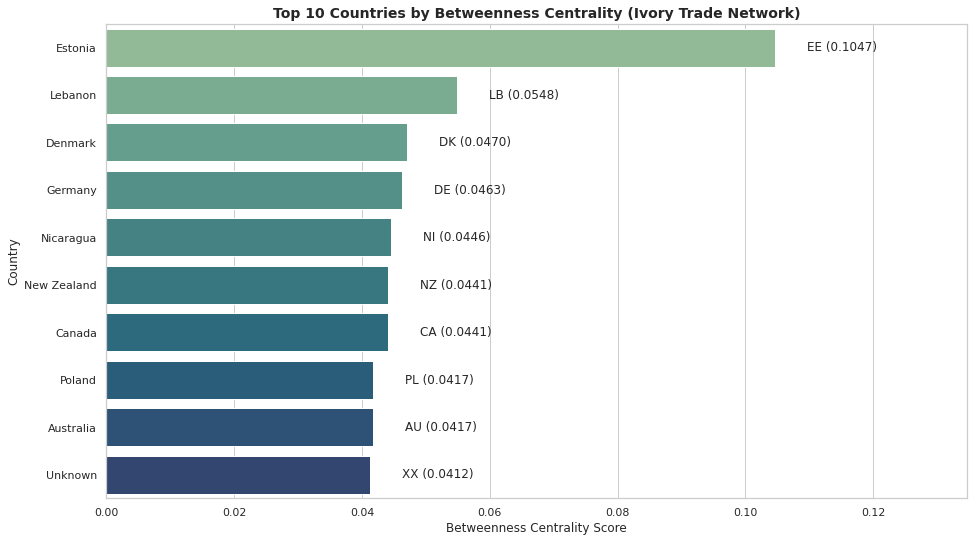

In [8]:
# Top 10 countries (code, full name, centrality score)
top_10 = [
    ('EE', 'Estonia', 0.1047),
    ('LB', 'Lebanon', 0.0548),
    ('DK', 'Denmark', 0.0470),
    ('DE', 'Germany', 0.0463),
    ('NI', 'Nicaragua', 0.0446),
    ('NZ', 'New Zealand', 0.0441),
    ('CA', 'Canada', 0.0441),
    ('PL', 'Poland', 0.0417),
    ('AU', 'Australia', 0.0417),
    ('XX', 'Unknown', 0.0412)
]

# Create DataFrame
df = pd.DataFrame(top_10, columns=["Code", "Country", "Centrality"])

# Set seaborn style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(x="Centrality", y="Country", data=df, palette="crest")

# Add annotations with offset to avoid edge clipping
for index, row in df.iterrows():
    ax.text(row["Centrality"] + 0.005, index,
            f'{row["Code"]} ({row["Centrality"]:.4f})',
            va='center', ha='left')

# Title and labels
plt.xlabel("Betweenness Centrality Score", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.title("Top 10 Countries by Betweenness Centrality (Ivory Trade Network)",
          fontsize=14, weight='bold')

# Extend x-axis to make room for annotations
plt.xlim(0, max(df["Centrality"]) + 0.03)

# Tight layout with padding
plt.tight_layout(pad=2)
plt.show()